### Evaluating and Debugging Generative AI 

When you are building gen ai application.Keeping track of metadata,Hyper parameters can get complicated.

To resolve this Weights and Biases comes handy.

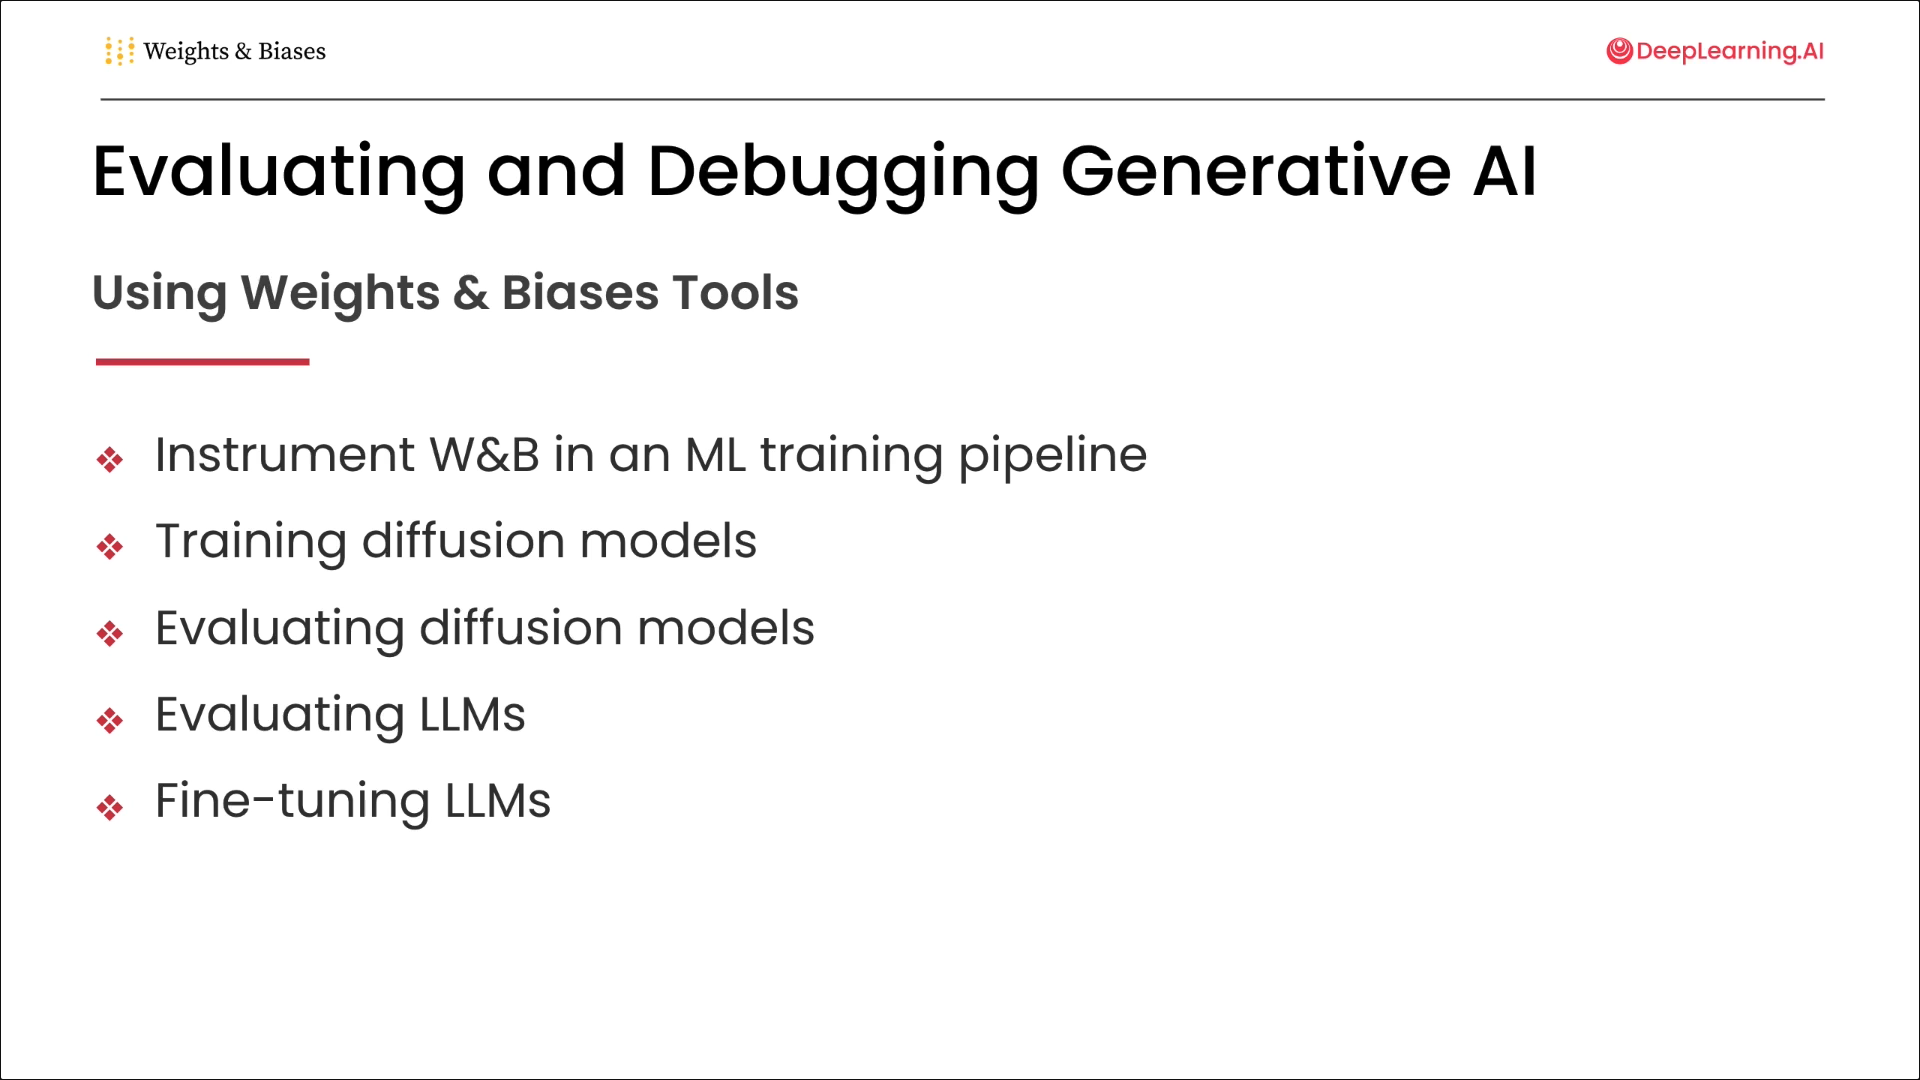

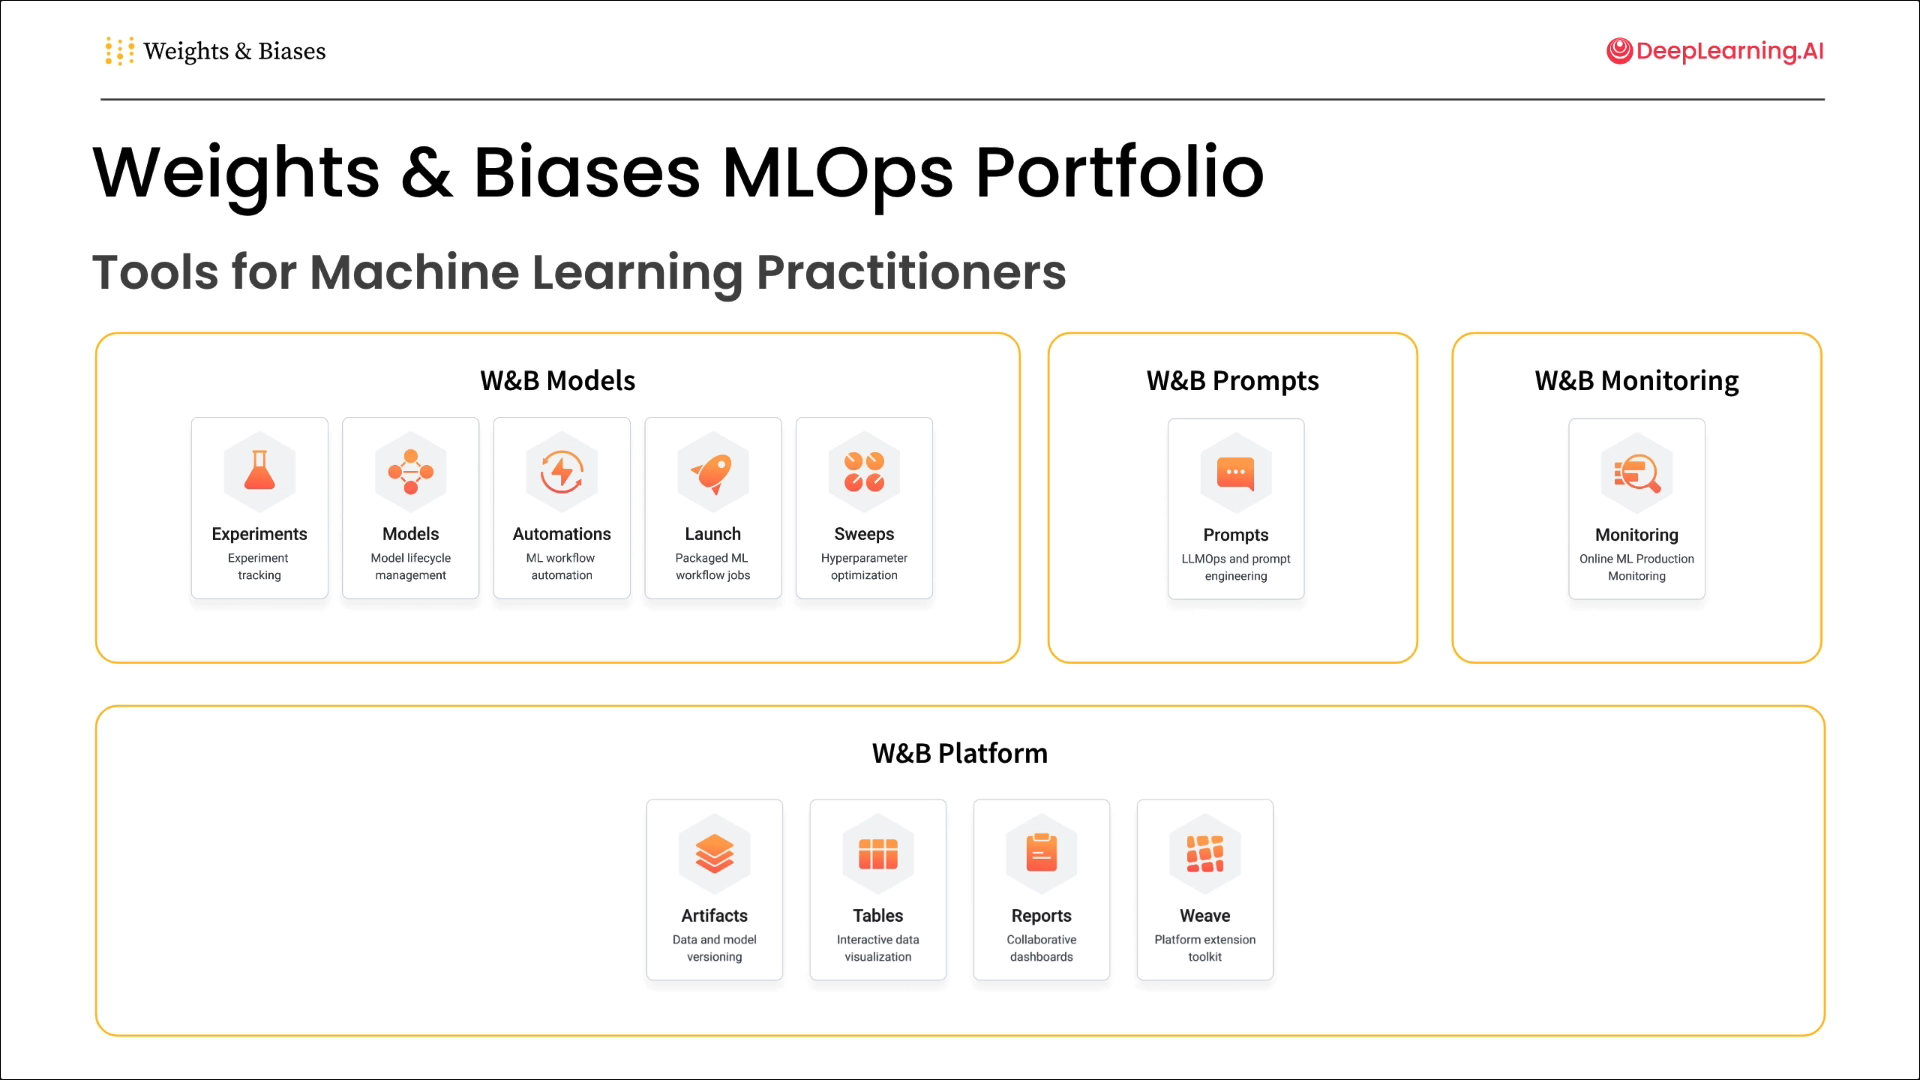

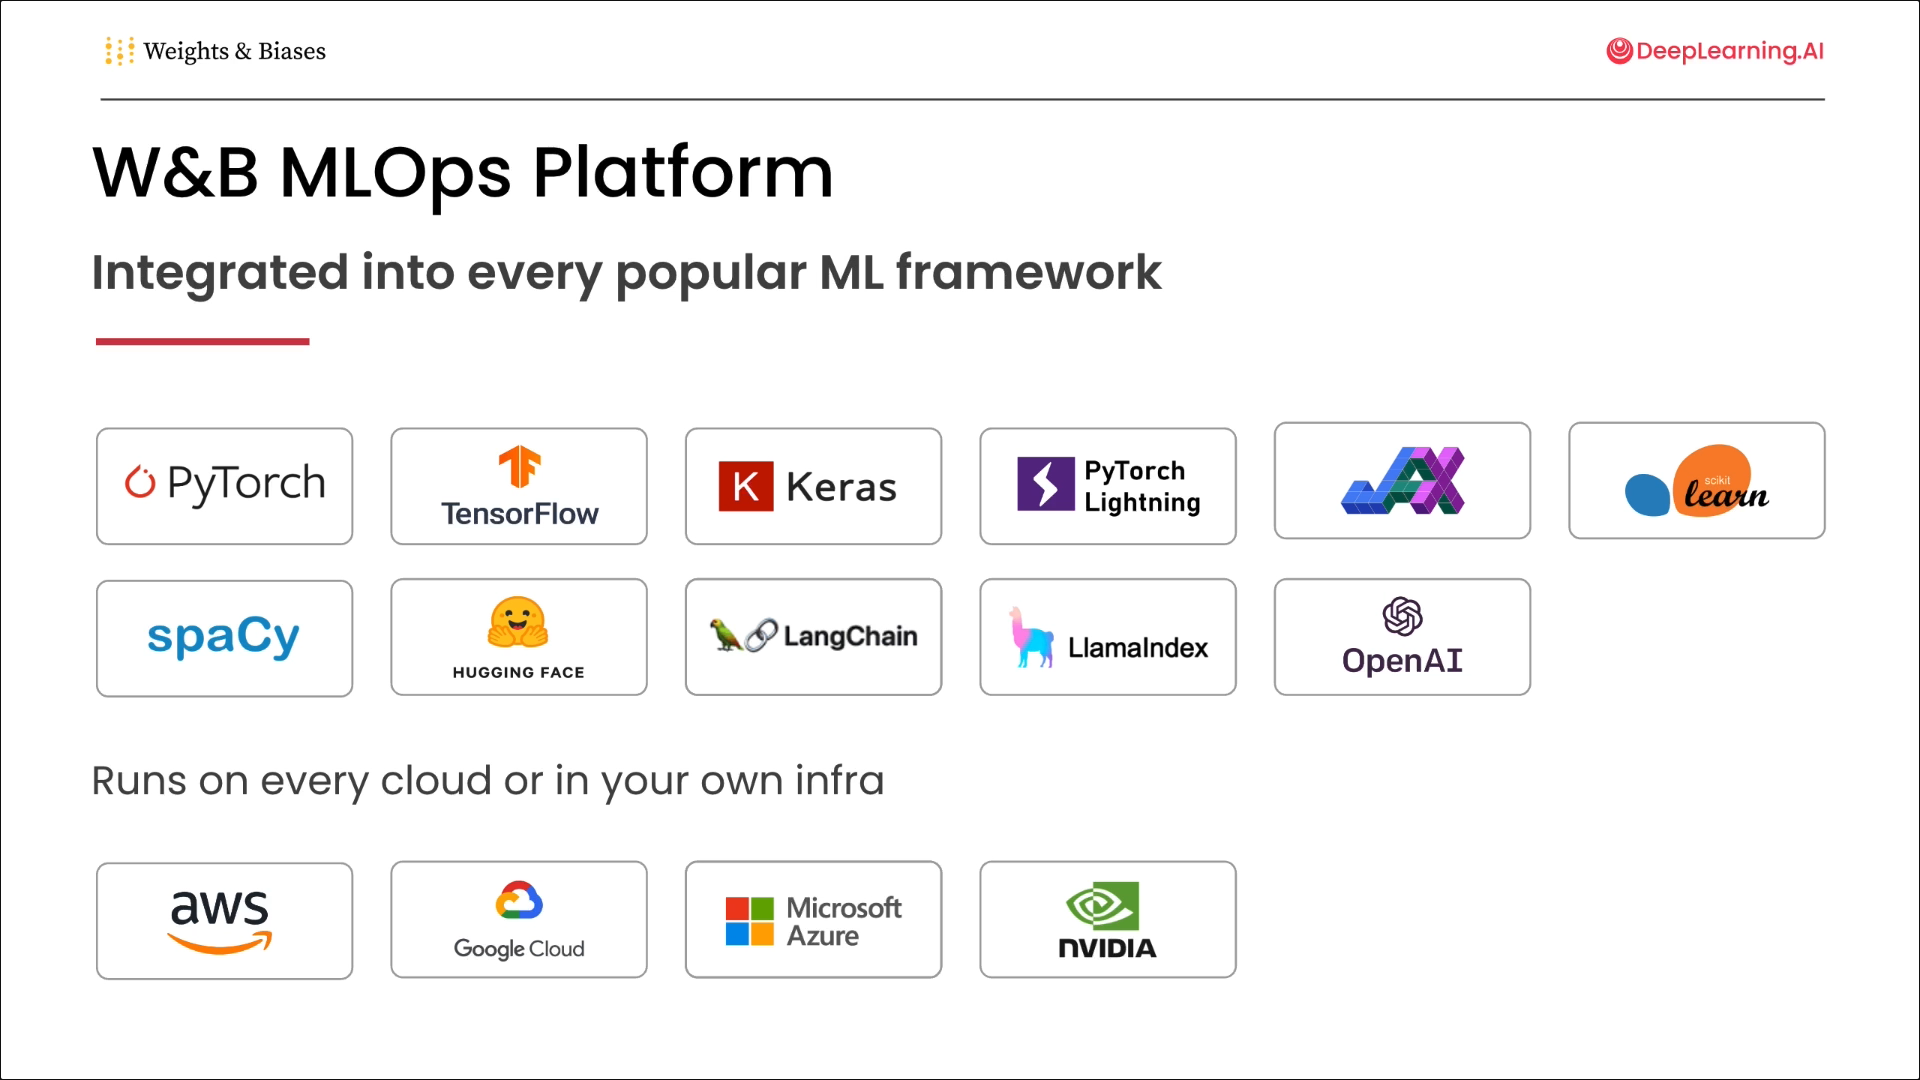

# Introduction to W&B

<!--- @wandbcode{dlai_01} -->

We will add `wandb` to sprite classification model training, so that we can track and visualize important metrics, gain insights into our model's behavior and make informed decisions for model improvements. We will also see how to compare and analyze different experiments, collaborate with team members, and reproduce results effectively.

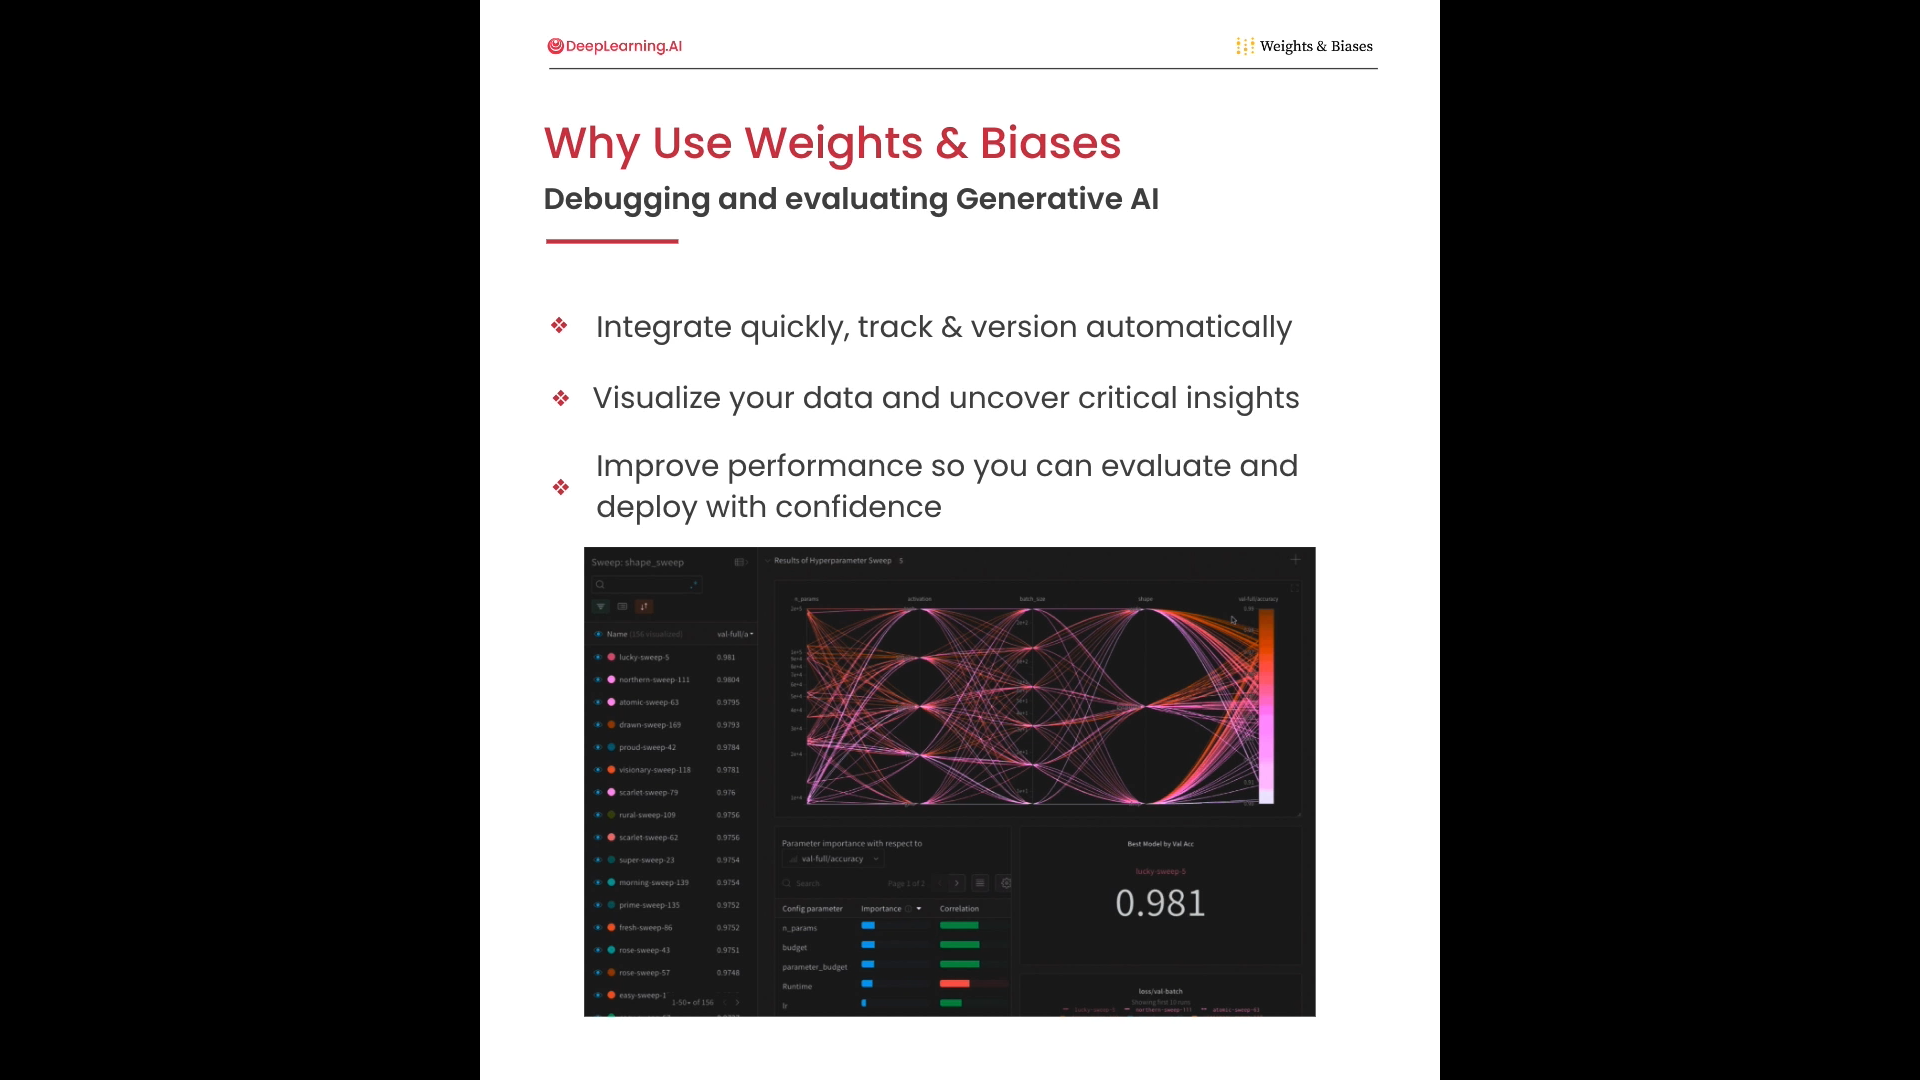

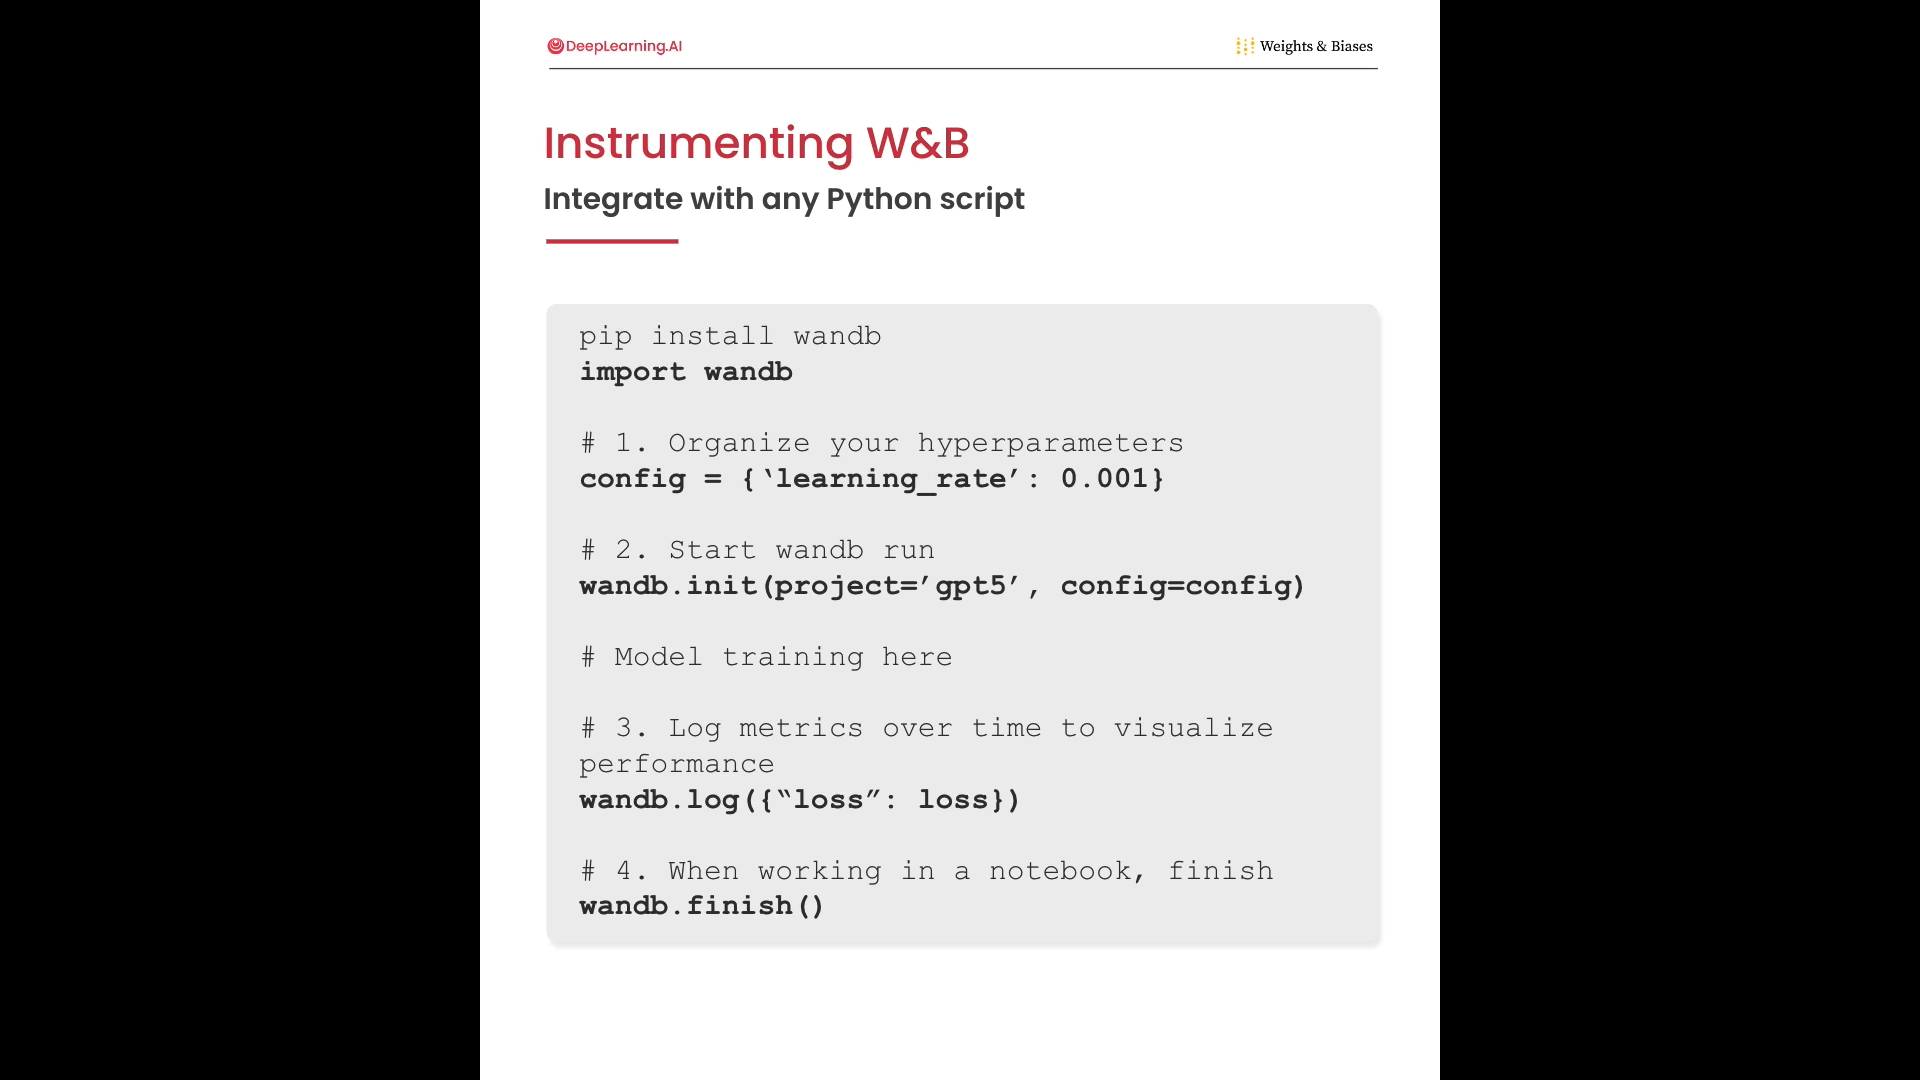

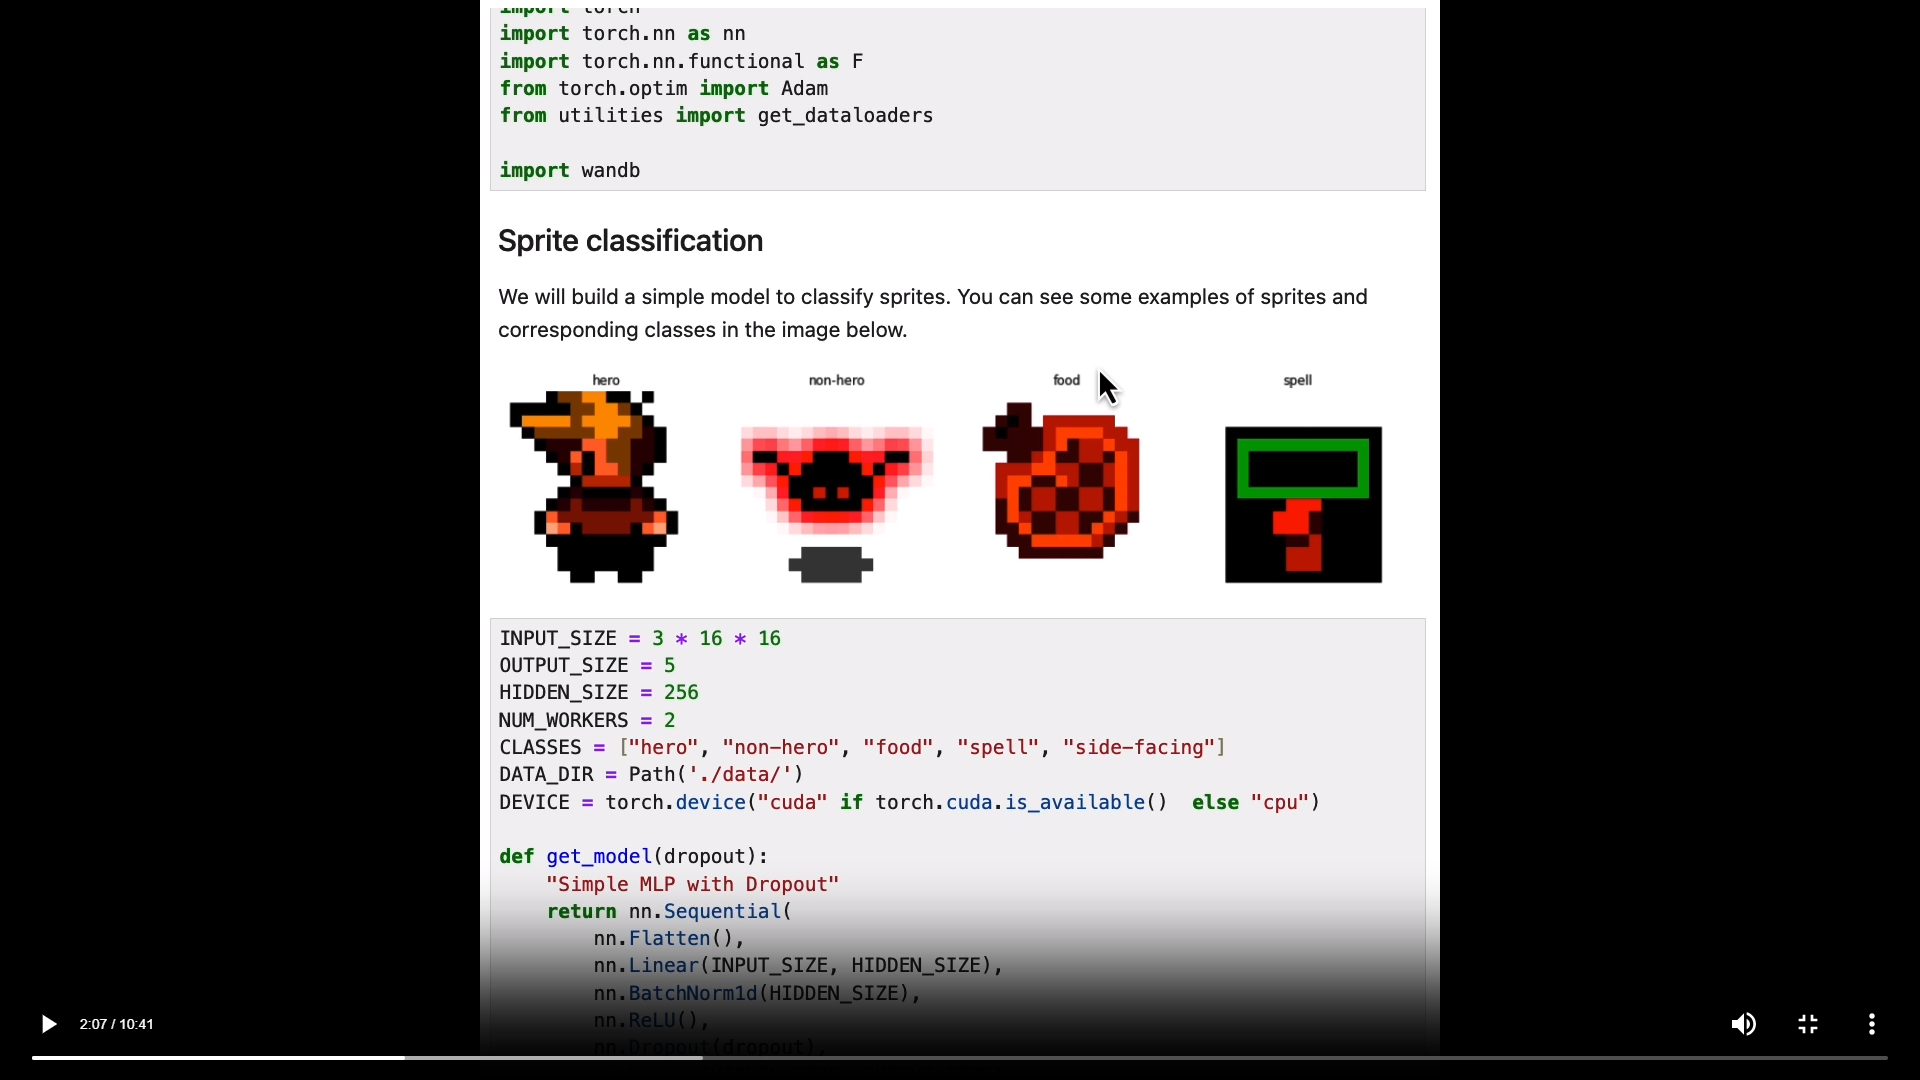

In [1]:
import math
from pathlib import Path
from types import SimpleNamespace
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import wandb

INPUT_SIZE = 3 * 16 * 16
OUTPUT_SIZE = 5
HIDDEN_SIZE = 256
NUM_WORKERS = 2
CLASSES = ["hero", "non-hero", "food", "spell", "side-facing"]
DATA_DIR = Path('./data/')
DEVICE = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

def get_model(dropout):
    "Simple MLP with Dropout"
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
        nn.BatchNorm1d(HIDDEN_SIZE),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
    ).to(DEVICE)



# Let's define a config object to store our hyperparameters
config = SimpleNamespace(
    epochs = 2,
    batch_size = 128,
    lr = 1e-5,
    dropout = 0.5,
    slice_size = 10_000,
    valid_pct = 0.2,
)

def train_model(config):
    "Train a model with a given config"
    
    wandb.init(
        project="dlai_intro",
        config=config,
    )

    # Get the data
    train_dl, valid_dl = get_dataloaders(DATA_DIR, 
                                         config.batch_size, 
                                         config.slice_size, 
                                         config.valid_pct)
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

    # A simple MLP model
    model = get_model(config.dropout)

    # Make the loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=config.lr)

    example_ct = 0

    for epoch in tqdm(range(config.epochs), total=config.epochs):
        model.train()

        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            train_loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            example_ct += len(images)
            metrics = {
                "train/train_loss": train_loss,
                "train/epoch": epoch + 1,
                "train/example_ct": example_ct
            }
            wandb.log(metrics)
            
        # Compute validation metrics, log images on last epoch
        val_loss, accuracy = validate_model(model, valid_dl, loss_func)
        # Compute train and validation metrics
        val_metrics = {
            "val/val_loss": val_loss,
            "val/val_accuracy": accuracy
        }
        wandb.log(val_metrics)
    
    wandb.finish()


def validate_model(model, valid_dl, loss_func):
    "Compute the performance of the model on the validation dataset"
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.inference_mode():
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(images)
            val_loss += loss_func(outputs, labels) * labels.size(0)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            
    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)


e:\Github\LLM\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### W&B account
The next cell will log you into the Weights and Biases site anonymously, that is without a unique login. You can also sign up for a free account if you wish to save your work, but that is not needed to finish the course.

In [2]:
wandb.login(anonymous="allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anony-mouse-811638375745038681. Use `wandb login --relogin` to force relogin


True

In [ ]:
train_model(config)

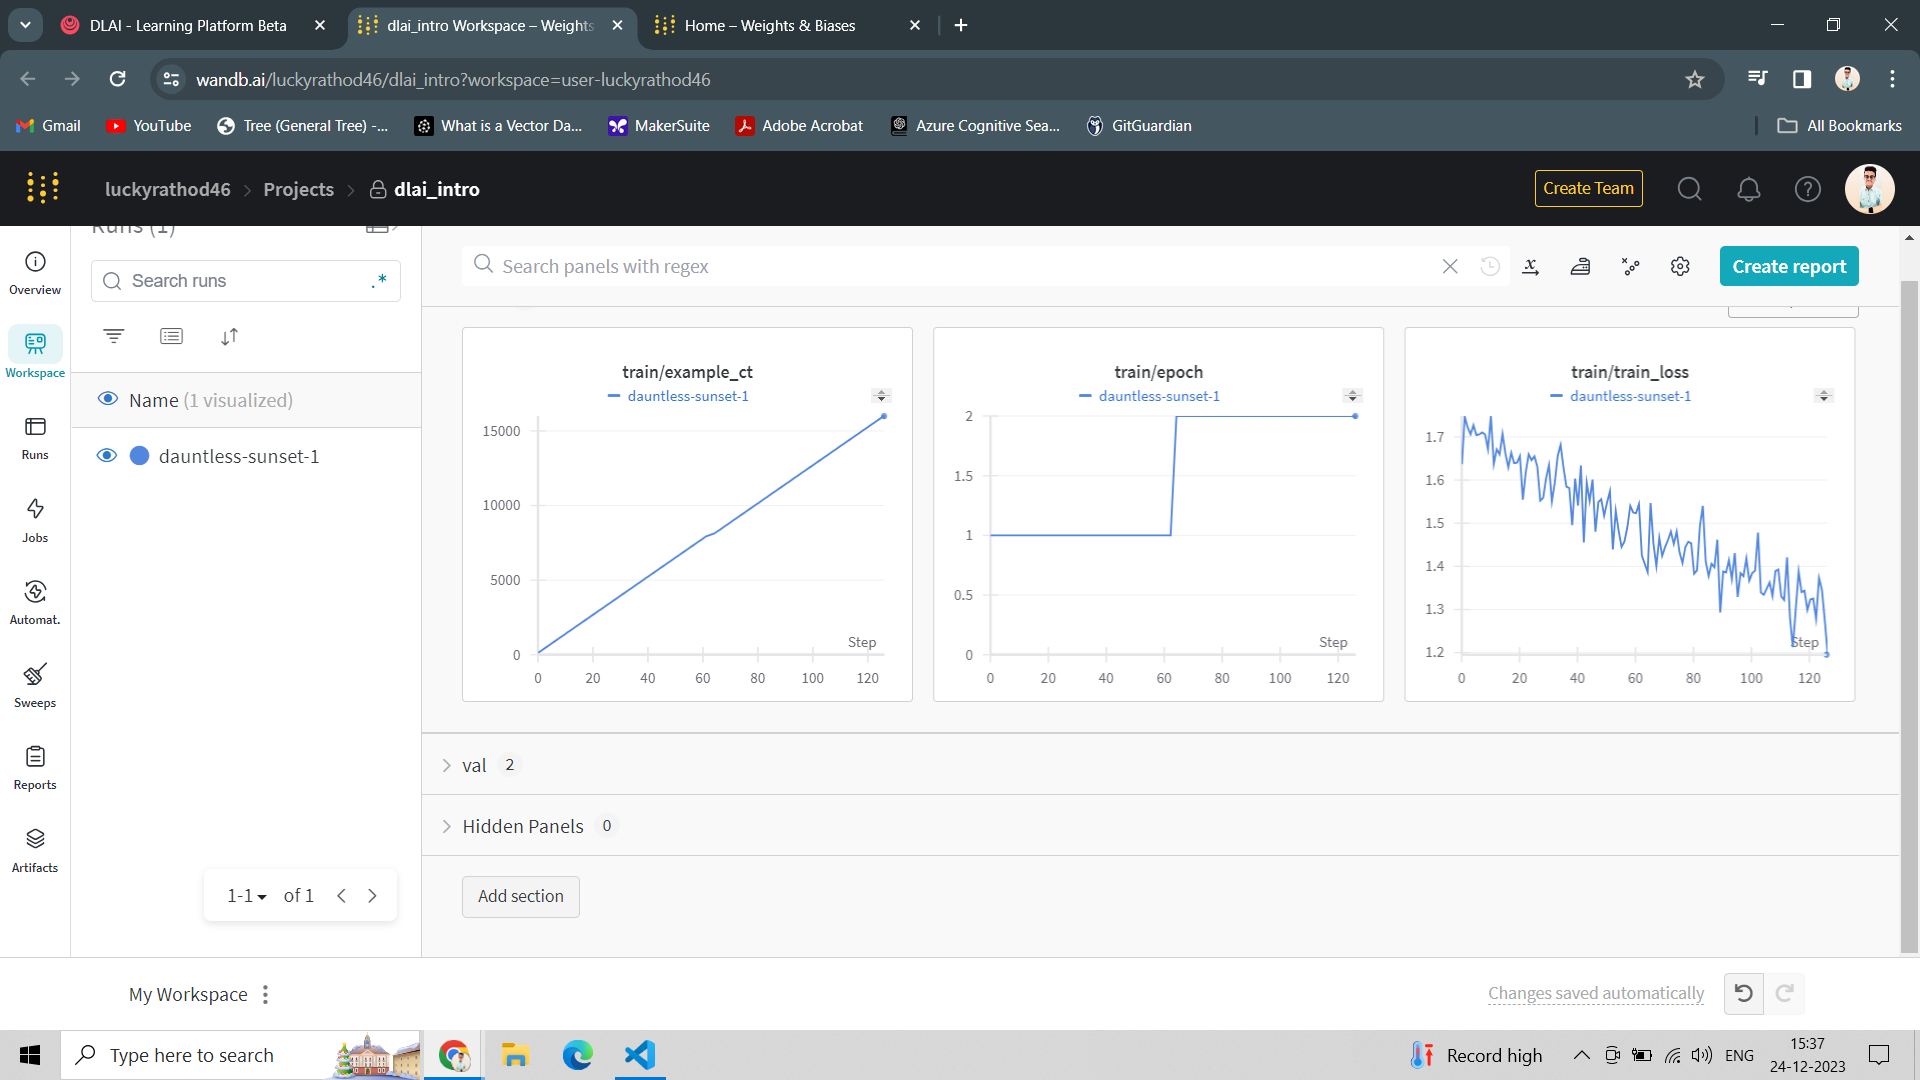

In [ ]:
# So let's change the learning rate to a 1e-3 
# and see how this affects our results.
config.lr = 1e-4
train_model(config)

In [ ]:
config.lr = 1e-4
train_model(config)

In [ ]:
config.dropout = 0.1
config.epochs = 1
train_model(config)

In [ ]:
config.lr = 1e-3
train_model(config)

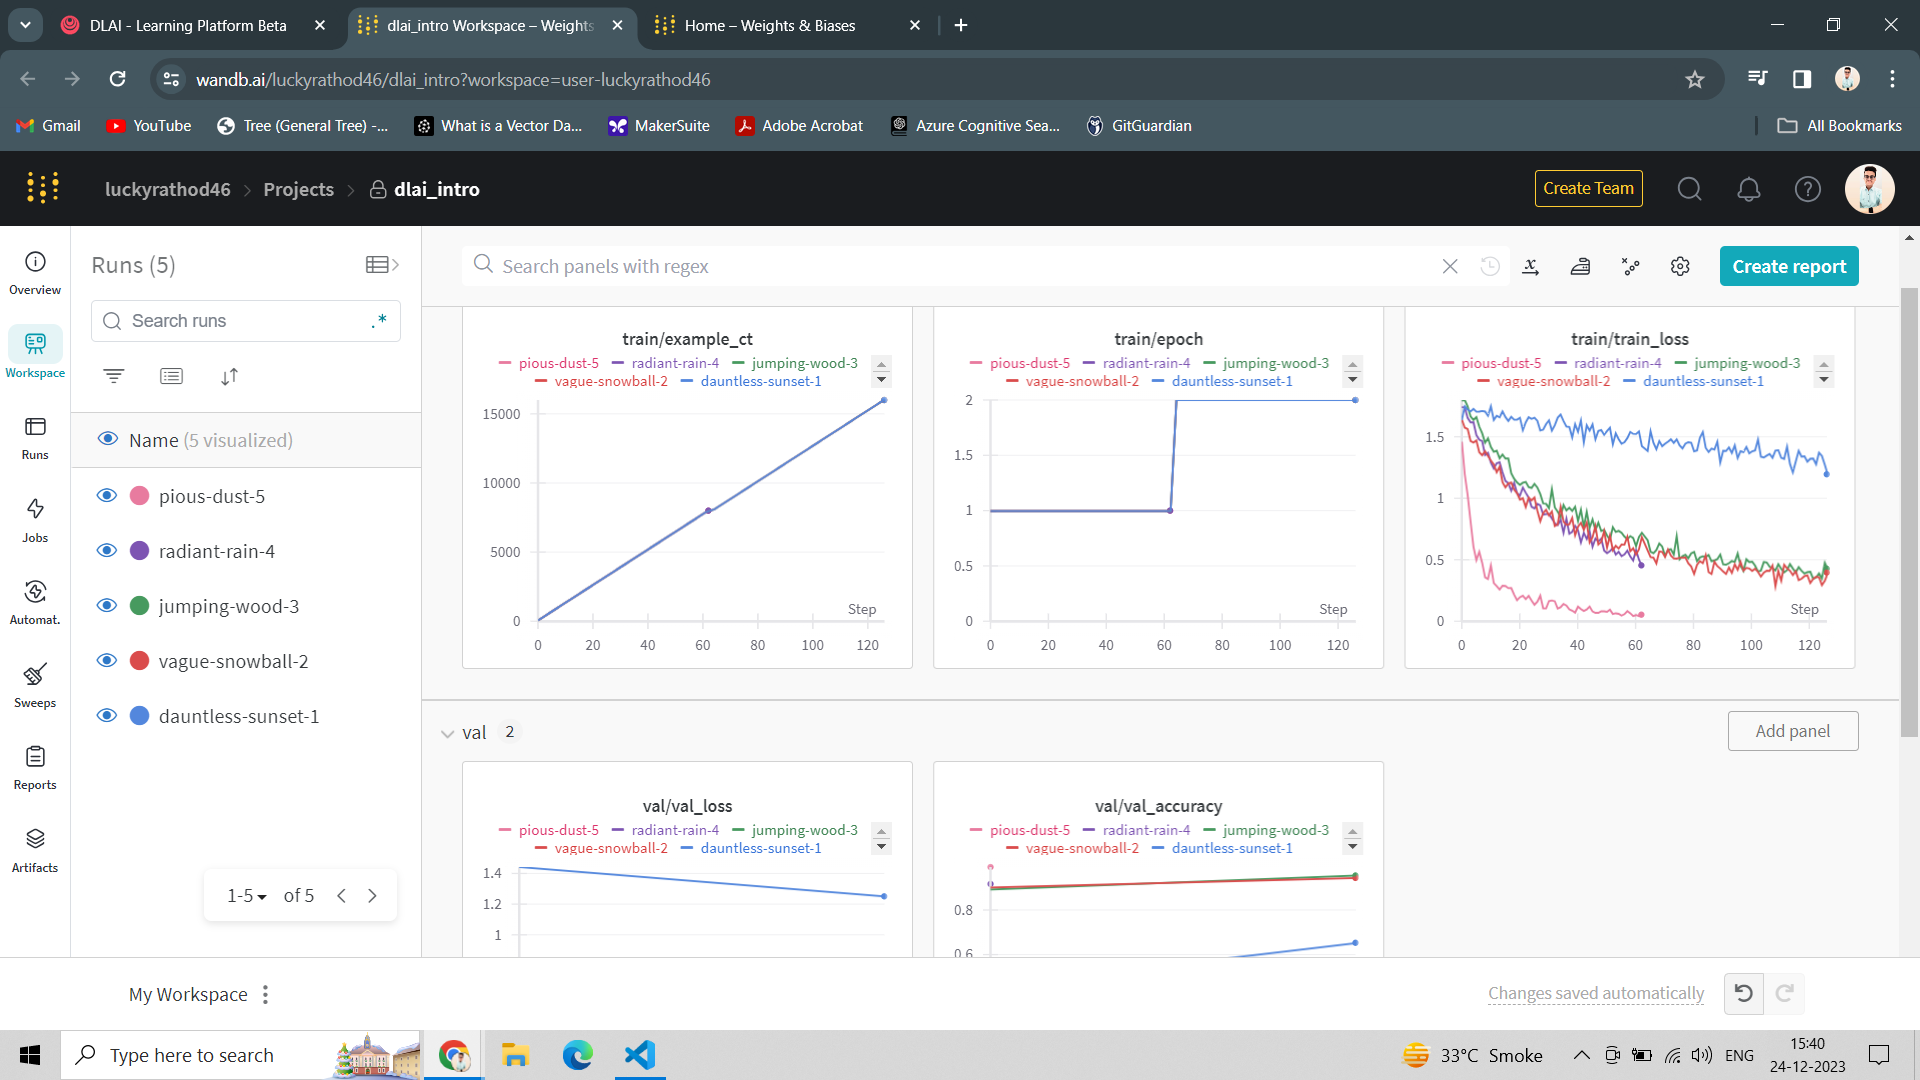

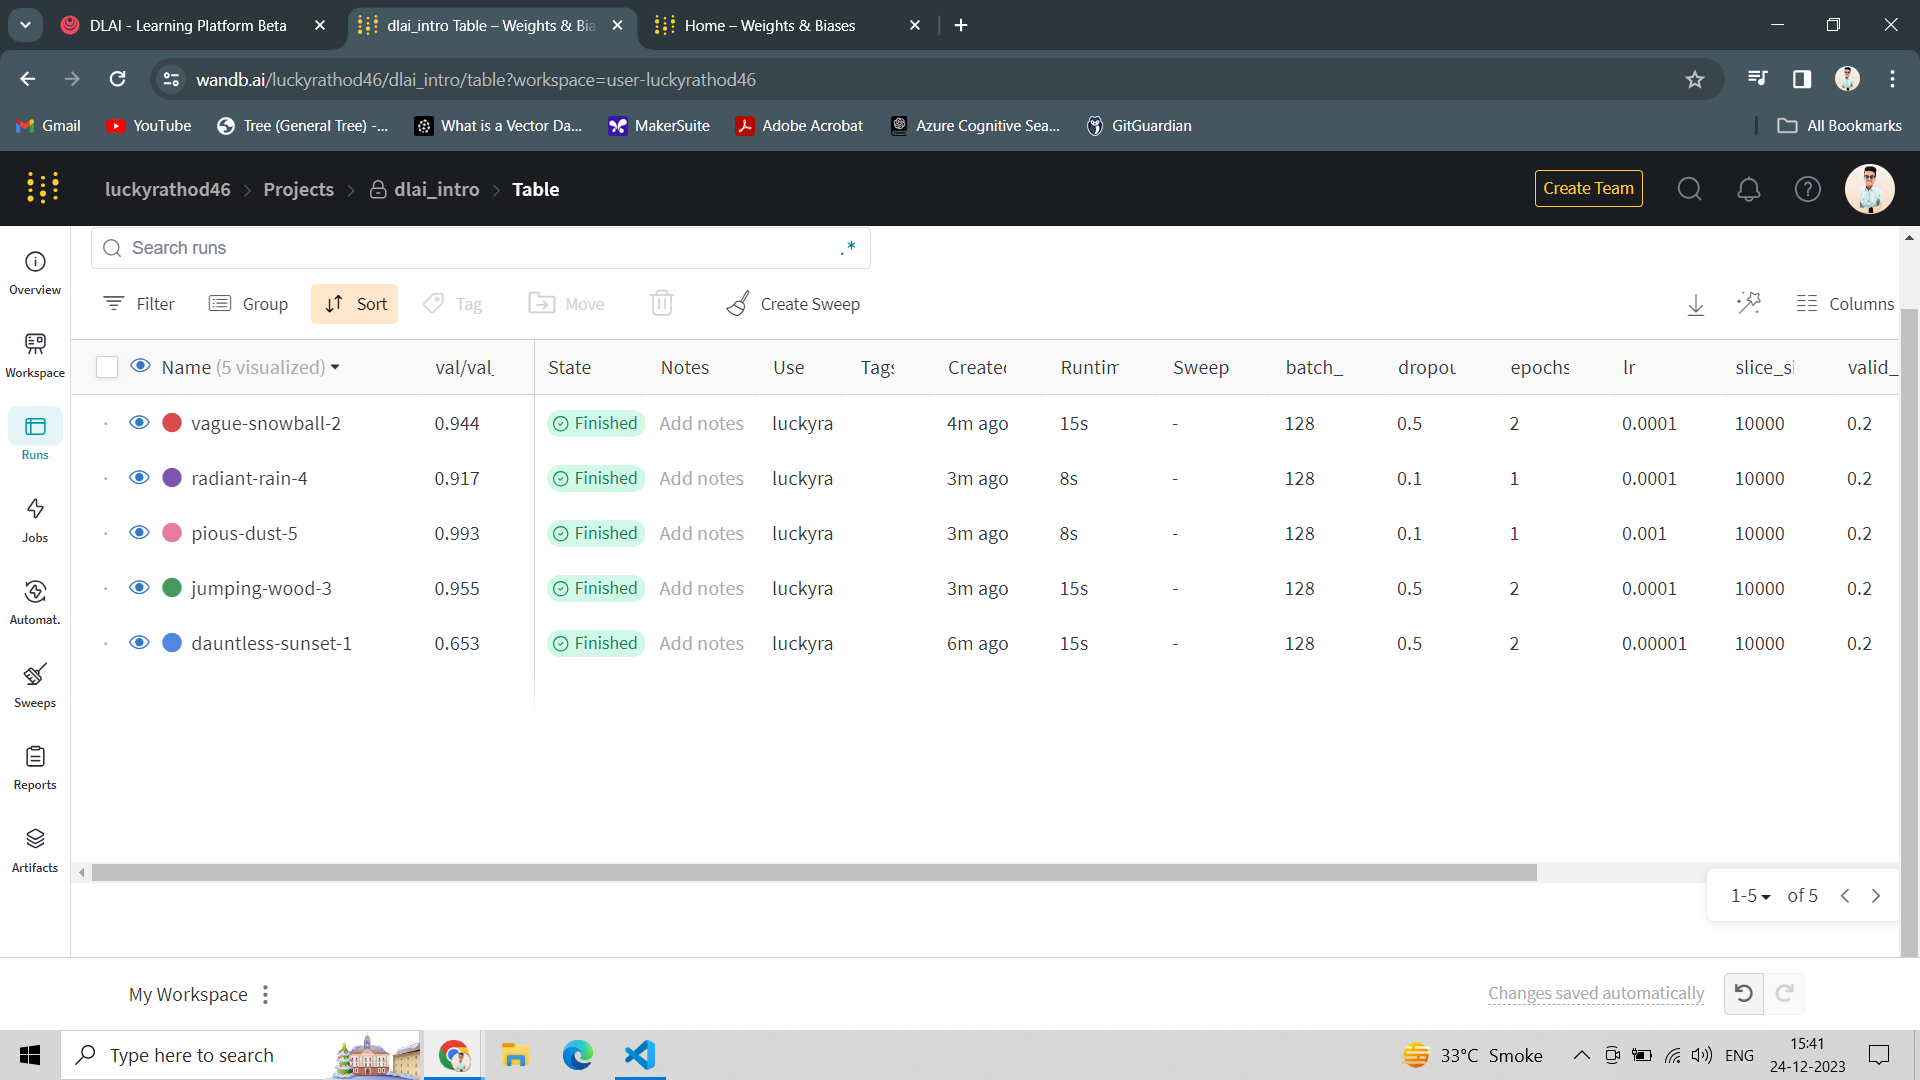

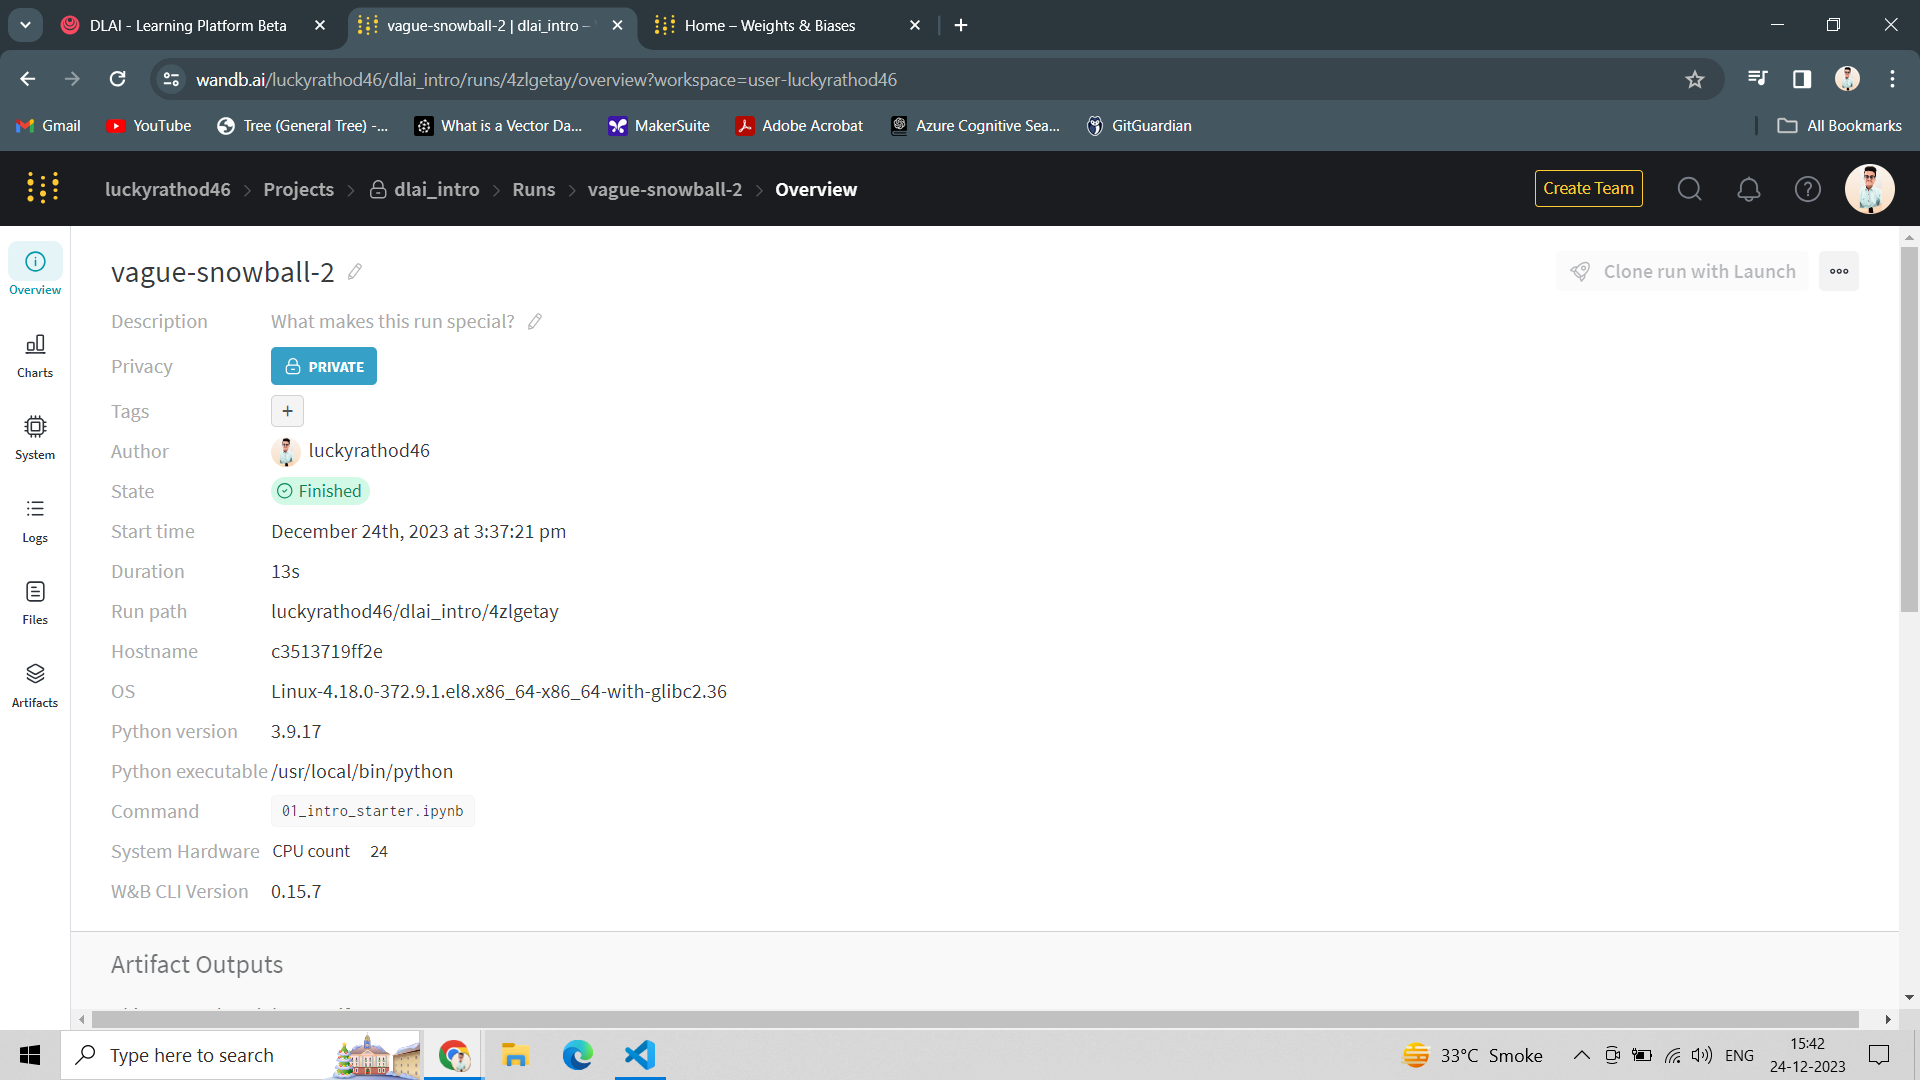

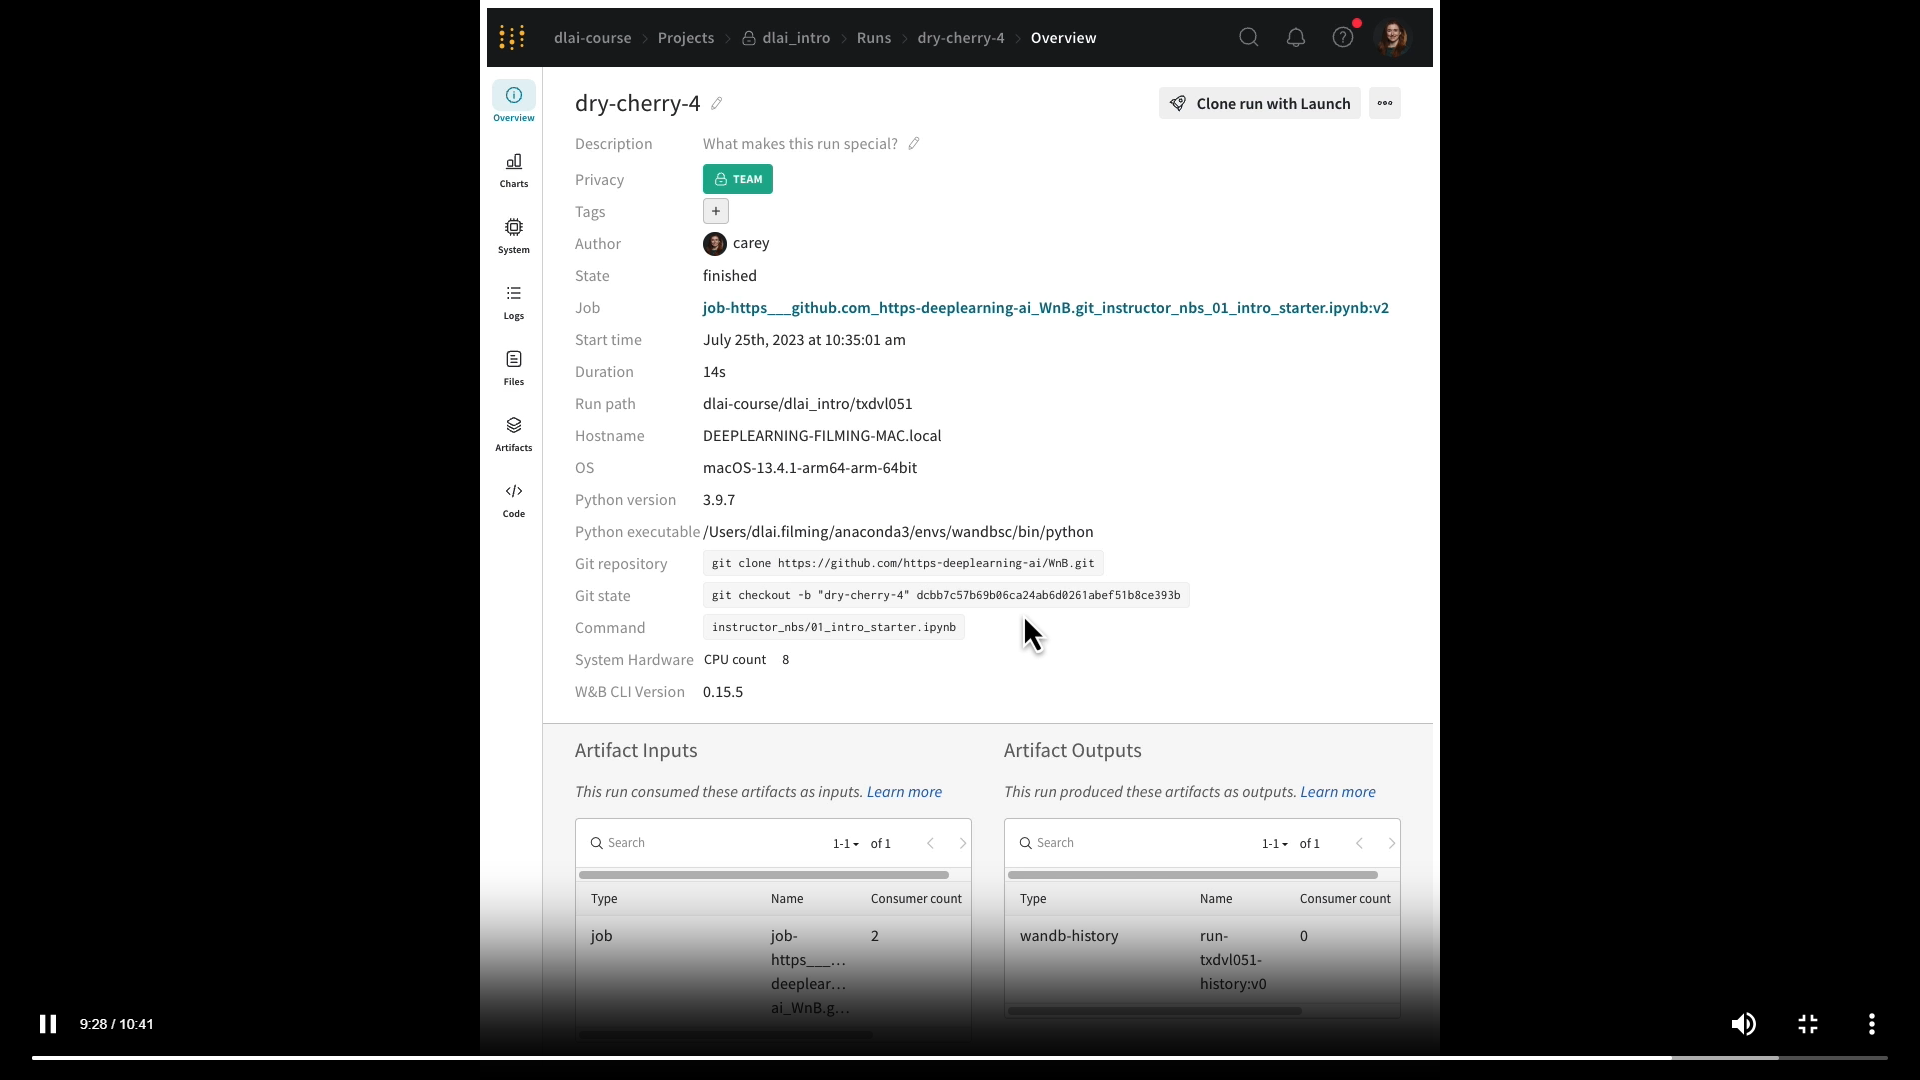